# Importing  libraries and reading data

In [348]:
import pandas as pd 
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from plotly.offline import iplot
from plotly.subplots import make_subplots

import warnings
warnings.simplefilter(action="ignore")
sns.set_theme(palette=sns.color_palette("muted"),style="darkgrid")

In [349]:
data = pd.read_csv("/kaggle/input/imdb-india-movies/IMDb Movies India.csv",encoding='latin-1')

# Data cleaning

In [352]:
data.isna().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

## Removing NaN values

In [353]:
data= data.dropna(subset=["Year","Genre","Director","Actor 1","Actor 2","Actor 3","Rating"])

In [354]:
data = data.dropna().reset_index(drop=True)

## Changing duration and votes to numeric

In [356]:
data["Duration"] = data.loc[:,"Duration"].str.replace(" min","")
data["Duration"] = pd.to_numeric(data.loc[:,"Duration"])

In [357]:
data["Votes"] = data.loc[:,"Votes"].str.replace(",","")
data["Votes"] = pd.to_numeric(data.loc[:,"Votes"])

In [358]:
data.shape

(5659, 10)

## Removing duplicated data

In [359]:
data.duplicated(subset=["Name","Year"]).sum()

2

In [360]:
data=data.drop_duplicates(keep="first",subset=["Name","Year"]).reset_index(drop=True)

In [361]:
data.columns

Index(['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director',
       'Actor 1', 'Actor 2', 'Actor 3'],
      dtype='object')

## Cleaning Genre and year columns and adding new genre column for further analysis

In [362]:
data["Year"] = data.loc[:,"Year"].str.extract(r"(\d{4})")
data["Year"] = pd.to_numeric(data.loc[:,"Year"])

In [363]:
data["Genre"] = data.loc[:,"Genre"].str.replace("Musical","Music")

In [364]:
data["Main_genre"] = data.loc[:,"Genre"].str.extract("(^\w{1,11})")

In [365]:
data["Main_genre"].unique()

array(['Drama', 'Comedy', 'Horror', 'Action', 'Crime', 'Thriller',
       'Adventure', 'Sport', 'Biography', 'Documentary', 'Mystery',
       'Music', 'Romance', 'Fantasy', 'Sci', 'Family', 'History',
       'Animation', 'War'], dtype=object)

## Removing outliers using zscore method

In [366]:
data.describe()

,Year,Duration,Rating,Votes
count,5657.000000,5657.00000,5657.000000,5657.00000
mean,1996.254198,133.44087,5.897967,2698.59802
std,19.729583,25.32374,1.381035,13653.82378
min,1931.000000,21.00000,1.100000,5.00000
25%,1983.000000,119.00000,5.000000,30.00000
50%,2002.000000,135.00000,6.100000,131.00000
75%,2013.000000,150.00000,6.900000,923.00000
max,2021.000000,321.00000,10.000000,591417.00000


In [367]:
data = data[(np.abs(stats.zscore(data[['Rating','Votes','Duration']])) < 3).all(axis=1)]

In [368]:
data.shape

(5545, 11)

# Univariate analysis

* Rating and duration are pretty much normally distributed
* Votes are right skewed and has alot of outliers but we cannot remove them

## Distribution of movies across Genres

In [372]:
data.Genre.value_counts().reset_index()

,Genre,count
0,Drama,833
1,"Drama, Romance",325
2,"Action, Crime, Drama",324
3,"Action, Drama",202
4,"Comedy, Drama",198
...,...,...
355,"History, Romance",1
356,"Drama, History, Sport",1
357,"Animation, Comedy, Drama",1
358,"Family, Drama, Thriller",1


In [373]:
genres = data.Main_genre.value_counts().reset_index()
iplot(px.pie(data_frame=genres,names=genres.Main_genre,values=genres["count"],title="Number of movies by Genre",height=1050)\
      .update_traces(textinfo="value+percent"))

* The top 3 genres in number of movies are Drama,Action and Comedy 

# Multivariate analysis

## Which genres are the highest rated?

In [374]:
data.groupby("Main_genre")["Rating"].mean().sort_values(ascending = False)

Main_genre
Documentary    7.566667
History        7.225000
Biography      6.598701
Sci            6.325000
Family         6.296154
Fantasy        6.251613
Drama          6.243574
Adventure      6.132673
Music          6.121111
Crime          6.092075
Animation      6.072500
Mystery        5.815517
Comedy         5.808368
Sport          5.800000
Romance        5.589809
Action         5.509474
Thriller       5.332584
Horror         4.688976
War            4.333333
Name: Rating, dtype: float64

In [375]:
rating_by_genre = data.groupby("Main_genre")["Rating"].mean().sort_values(ascending = False)
iplot(px.bar(data_frame=rating_by_genre))

## Distribution of movies over time

In [376]:
movies_by_year = data["Year"].value_counts().reset_index().sort_values(by="Year")

iplot(px.line(data_frame=movies_by_year,x="Year",y="count",title="Number of Movies over the years",\
              color_discrete_sequence=["green"]))

* The number of movies are increasing over the years peaking in 2019 at 224 movies

## Rating  and number of votes  over the years

In [377]:
Rating_by_years = data.groupby("Year").agg({"Rating":"mean","Votes":"sum"}).reset_index()

In [378]:
iplot(px.line(data_frame=Rating_by_years,x="Year",y="Rating",markers=True,color_discrete_sequence=["green"],height=400))

In [379]:
iplot(px.line(data_frame=Rating_by_years,x="Year",y="Votes",color_discrete_sequence=["Red"],markers=True,height=400))

* While rating is higher in the early years (before 1990) votes are extemely low compared to after 1999
* Votes started increasing after 1990 to almost double in the next year and peaked at 650k in 2018

In [380]:
def top_10_rating(col):
    return data.groupby(col)["Rating"].agg(["mean","count"])\
    .query("count >=10")\
    .sort_values(by="mean",ascending=False)[:10]\
    .reset_index()

In [381]:
top_10_director = top_10_rating("Director")

iplot(px.bar(data_frame=top_10_director,x="Director",y="mean",text="count",labels = {'mean':'Rating','count':'Number of movies'},\
            title="Top 10 Directors with more than 10 movies by rating"))

In [382]:
top_10_actors1 = top_10_rating("Actor 1")

iplot(px.bar(data_frame=top_10_actors1,x="Actor 1",y="mean",text="count",\
    labels = {'Actor 1':'Main Actor','mean':'Rating','count':'Number of movies'},\
             title="Top 10 Main actors with more than 10 movies by rating"))

In [383]:
top_10_actors2 = top_10_rating("Actor 2")

iplot(px.bar(data_frame=top_10_actors2,x="Actor 2",y="mean",text="count",labels = {'mean':'Rating','count':'Number of movies'},\
            title="Top 10 secondary actors with more than 10 movies by rating"))

In [384]:
top_10_actors3 = top_10_rating("Actor 3")

iplot(px.bar(data_frame=top_10_actors3,x="Actor 3",y="mean",text="count",labels = {'mean':'Rating','count':'Number of movies'},\
            title="Top 10 Third main actors with more than 10 movies by rating"))

# Importing libraries for machine learning and transforming data

In [385]:
from sklearn.model_selection import train_test_split,cross_val_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.preprocessing import RobustScaler,StandardScaler,MaxAbsScaler,MinMaxScaler
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
import sklearn.metrics as metrics
import scikitplot as skplt
import category_encoders as ce

In [386]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('Median absolute error: ',round(median_absolute_error,4))

## Dropping uncessacry columns and splitting data into x and y

In [387]:
data =data.drop(columns=["Name","Main_genre"])

In [388]:
X = data.drop(columns="Rating")
y = data["Rating"]

In [389]:
X

,Year,Duration,Genre,Votes,Director,Actor 1,Actor 2,Actor 3
0,2019,109,Drama,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
1,2019,110,"Comedy, Romance",35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
2,1997,147,"Comedy, Drama, Music",827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
3,2005,142,"Drama, Romance, War",1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
4,2012,82,"Horror, Mystery, Thriller",326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia
...,...,...,...,...,...,...,...,...
5652,2015,115,Drama,408,Mozez Singh,Vicky Kaushal,Sarah Jane Dias,Raaghavv Chanana
5653,2001,153,"Biography, Drama, History",1496,Shyam Benegal,Karisma Kapoor,Rekha,Manoj Bajpayee
5654,1989,125,"Action, Crime, Drama",44,S.P. Muthuraman,Chiranjeevi,Jayamalini,Rajinikanth
5655,1999,129,"Action, Drama",655,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani


# Encoding data using JamesSteinEncoder

In [390]:
encoder = ce.JamesSteinEncoder(return_df=True)

In [391]:
encoder.fit(X,y)
X = encoder.transform(X.loc[:,:])

In [392]:
X

,Year,Duration,Genre,Votes,Director,Actor 1,Actor 2,Actor 3
0,2019,109,6.190741,8,7.000000,6.827112,7.000000,7.000000
1,2019,110,5.792333,35,4.400000,5.598501,4.400000,4.453861
2,1997,147,5.978972,827,5.590219,5.246126,5.774658,5.878363
3,2005,142,6.401041,1086,7.173496,5.653301,6.702394,6.198561
4,2012,82,5.706343,326,5.600000,5.600000,5.884089,5.600000
...,...,...,...,...,...,...,...,...
5652,2015,115,6.190741,408,6.100000,6.126083,6.100000,5.852186
5653,2001,153,6.570957,1496,6.968314,5.248634,5.844167,5.789483
5654,1989,125,5.801954,44,6.203445,6.208974,5.800000,6.016249
5655,1999,129,5.676591,655,5.375500,5.582148,4.911970,5.803593


# Normalizing data using Robust scaler

In [393]:
scaler = RobustScaler()
scaler.fit(X)
X.loc[:,:] = scaler.transform(X.loc[:,:])

In [394]:
X

,Year,Duration,Genre,Votes,Director,Actor 1,Actor 2,Actor 3
0,0.580645,-0.838710,0.625425,-0.141657,1.049219,1.058406,1.166050,1.244936
1,0.580645,-0.806452,-0.167667,-0.109244,-1.479828,-0.378927,-1.662776,-1.689504
2,-0.129032,0.387097,0.203867,0.841537,-0.322090,-0.791165,-0.167134,-0.047758
3,0.129032,0.225806,1.044060,1.152461,1.217981,-0.314818,0.842252,0.321273
4,0.354839,-1.709677,-0.338843,0.240096,-0.312576,-0.377173,-0.048072,-0.368572
...,...,...,...,...,...,...,...,...
5652,0.451613,-0.645161,0.625425,0.338535,0.173780,0.238283,0.186841,-0.077927
5653,0.000000,0.580645,1.382303,1.644658,1.018398,-0.788231,-0.091508,-0.150192
5654,-0.387097,-0.322581,-0.148515,-0.098439,0.274402,0.335256,-0.139562,0.111157
5655,-0.064516,-0.193548,-0.398070,0.635054,-0.530949,-0.398058,-1.105747,-0.133931


# Training XGBoost model

In [395]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=7,shuffle=True)

In [396]:
xgb_model = XGBRegressor(objective ='reg:squarederror',gamma=0.09,learning_rate=0.08,subsample=0.7)

In [397]:
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.09, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Evaluating XGBoost model

In [398]:
xgb_model.score(X_train,y_train)

0.9303447793703494

In [399]:
xgb_model.score(X_test,y_test)

0.858351669095752

In [400]:
y_pred = xgb_model.predict(X_test)
print(f"Report:Lgbm model")
print(f"{regression_results(y_test, y_pred)}\n")

Report:Lgbm model
explained_variance:  0.8584
mean_squared_log_error:  0.0064
r2:  0.8584
MAE:  0.3425
MSE:  0.2459
RMSE:  0.4959
Median absolute error:  0.2255
None



In [401]:
score = cross_val_score(xgb_model,X,y,cv=10)
avg = np.mean(score)
print(f"cross validation score for XGBoost:{score}")
print(f"average cross validation score for XGBoost:{avg}\n")

cross validation score for XGBoost:[0.84958444 0.85796474 0.86210572 0.86311445 0.86657358 0.86424627
 0.85113039 0.84348962 0.82976873 0.88102786]
average cross validation score for XGBoost:0.8569005800073872



## Feature importances by the model

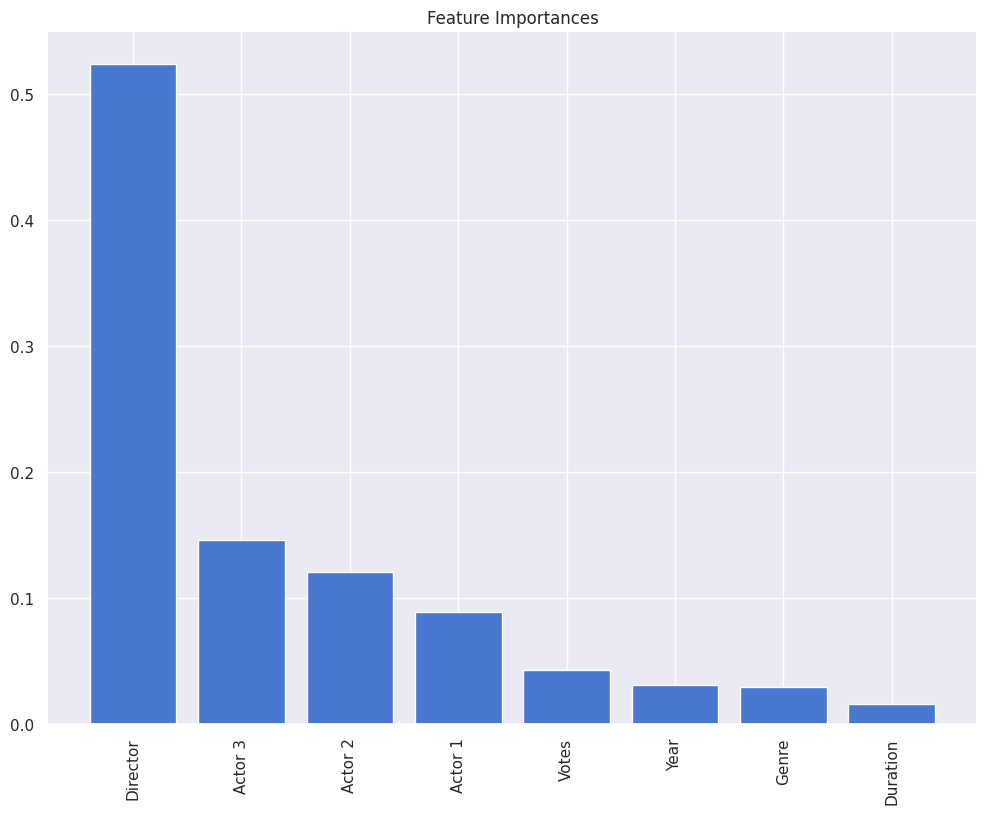

In [402]:
fs = xgb_model.feature_importances_
feature_names = X.columns

feature_importances = pd.DataFrame(fs,feature_names).sort_values(by=0,ascending=False)
plt.figure(figsize=(12, 9))
plt.title("Feature Importances")
plt.bar(x=feature_importances.index,height=feature_importances[0])
plt.xticks(rotation=90)

plt.show()

# Here we try to predict new data we chose data close to row 10 of the head

In [403]:
data.head(15)

,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
1,2019,110,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
2,1997,147,"Comedy, Drama, Music",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
3,2005,142,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
4,2012,82,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia
5,2014,116,"Action, Crime, Thriller",4.0,11,Biju Bhaskar Nair,Augustine,Fathima Babu,Byon
6,2004,96,Drama,6.2,17,Madhu Ambat,Rati Agnihotri,Gulshan Grover,Atul Kulkarni
7,2016,120,Horror,5.9,59,Arshad Siddiqui,Pankaj Berry,Anubhav Dhir,Hritu Dudani
8,1991,161,"Horror, Romance, Thriller",6.5,983,Partho Ghosh,Jackie Shroff,Madhuri Dixit,Javed Jaffrey
9,2012,166,"Comedy, Drama, Romance",5.7,512,Rabi Kinagi,Jeet,Koyel Mallick,Sujoy Ghosh


In [404]:
new_data = pd.DataFrame({'Year':[2015],'Duration':[115],\
                         'Genre':'Comedy,Drama','Votes':[7123],'Director':['Sharat Katariya'],\
                         'Actor 1':['Jeet'],'Actor 2':['Rishi Kapoor'],'Actor 3':['Vijay Raaz'],})

In [405]:
new_data

,Year,Duration,Genre,Votes,Director,Actor 1,Actor 2,Actor 3
0,2015,115,"Comedy,Drama",7123,Sharat Katariya,Jeet,Rishi Kapoor,Vijay Raaz


## Scaling and Normalizing new data

In [406]:
new_data = encoder.transform(new_data)
new_data.loc[:,:] = scaler.transform(new_data.loc[:,:])

In [407]:
new_data

,Year,Duration,Genre,Votes,Director,Actor 1,Actor 2,Actor 3
0,0.451613,-0.645161,0.015966,8.39976,0.762922,0.305795,0.320959,0.081981


In [408]:
xgb_model.predict(new_data)

array([6.768497], dtype=float32)